In [32]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

use_months = pd.read_csv('use_log_months.csv')
customer = pd.read_csv('customer_join.csv')

In [3]:
use_months.head()

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [4]:
customer.head()
# 14분 까지

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,max,min,median,mean,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,8.0,1.0,4.5,4.166667,1.0,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,7.0,1.0,5.0,4.833333,1.0,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,5.0,3.0,4.0,4.000000,1.0,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,7.0,2.0,4.0,4.600000,1.0,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,2_야간,6000,2_일반,6.0,1.0,4.0,3.500000,1.0,2019-04-30,47


In [10]:
# 유저를 탈퇴 예측에 사용할 DataFrame을 만들기 위해 Pivot Table을 생성합니다.
uselog_pivot = pd.pivot_table(data = use_months, index = 'customer_id', columns = '연월', values ='count' )
uselog_pivot.head()

연월,201804,201805,201806,201807,201808,201809,201810,201811,201812,201901,201902,201903
customer_id,,,,,,,,,,,,
AS002855,4.0,5.0,5.0,5.0,3.0,7.0,3.0,5.0,2.0,6.0,5.0,4.0
AS008805,NaN,NaN,8.0,7.0,5.0,2.0,2.0,3.0,5.0,1.0,6.0,1.0
AS009013,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AS009373,3.0,4.0,4.0,7.0,6.0,6.0,5.0,4.0,4.0,7.0,6.0,5.0
AS015233,NaN,7.0,7.0,5.0,11.0,9.0,7.0,7.0,9.0,9.0,4.0,8.0


In [25]:
uselog = pd.DataFrame()
total_month = len(uselog_pivot.columns)

used_month = 2
for i in range(total_month - used_month): # range(10)
  selected_df = uselog_pivot.iloc[:,i:i+used_month] # 두개의 칼렴을 가지는 데이터프레임을 선택합니다.
  selected_df.loc[:,'연월'] = selected_df.columns[1]
  selected_df.columns = ['before_month_count', 'current_month_count', '연월']
  uselog = pd.concat([uselog, selected_df])
uselog = uselog[~uselog['current_month_count'].isna()] # current_month_count not null
uselog = uselog.reset_index()
uselog = uselog[['연월','customer_id', 'before_month_count', 'current_month_count']] # 위치 정렬

In [33]:
from dateutil.relativedelta import relativedelta

exit_customer = customer.query('is_deleted == 1') # 해지 유저만 선택
exit_customer.loc[:,'exit_date'] = None
exit_customer.loc[:,'end_date'] = pd.to_datetime(exit_customer['end_date'])
for i in range(len(exit_customer)):
  exit_customer['exit_date'].iloc[i] = exit_customer['end_date'].iloc[i] - relativedelta(months=1) # 해지 신청 달을 추적하기 위해 end_date에서 한달을 뺀 exit_date를 생성합니다.
exit_customer.loc[:,'연월'] = pd.to_datetime(exit_customer['exit_date']).dt.strftime('%Y%m') # datetime 자료형으로 수정 후 연월 칼럼을 생성합니다.
exit_customer.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,max,min,median,mean,routine_flg,calc_date,membership_period,exit_date,연월
708,TS511179,XXXXXX,C01,F,2016-05-01,2018-04-30,CA1,1,0_종일,10500,2_일반,3.0,3.0,3.0,3.0,0.0,2018-04-30,23,2018-03-30 00:00:00,201803
729,TS443736,XXXX,C02,M,2016-05-01,2018-04-30,CA1,1,1_주간,7500,2_일반,3.0,3.0,3.0,3.0,0.0,2018-04-30,23,2018-03-30 00:00:00,201803
730,HD542886,XX,C01,M,2016-05-01,2018-04-30,CA1,1,0_종일,10500,2_일반,1.0,1.0,1.0,1.0,0.0,2018-04-30,23,2018-03-30 00:00:00,201803
770,HD597545,XXXXX,C03,F,2016-06-01,2018-05-31,CA1,1,2_야간,6000,2_일반,4.0,3.0,3.5,3.5,1.0,2018-05-31,23,2018-04-30 00:00:00,201804
785,HI749296,XXXXX,C01,M,2016-06-01,2018-05-31,CA1,1,0_종일,10500,2_일반,3.0,3.0,3.0,3.0,0.0,2018-05-31,23,2018-04-30 00:00:00,201804


In [40]:
uselog['연월'] = uselog['연월'].astype(str) # merge 하기 위해 exit_customer와 dtype을 일치 시킵니다.
exit_uselog = pd.merge(uselog, exit_customer, on = ['연월','customer_id'], how = 'left')
exit_uselog = exit_uselog.dropna(subset = ['name'])
exit_uselog.head()

,연월,customer_id,before_month_count,current_month_count,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,max,min,median,mean,routine_flg,calc_date,membership_period,exit_date
19,201805,AS055680,3.0,3.0,XXXXX,C01,M,2018-03-01,2018-06-30,CA1,...,10500.0,2_일반,3.0,3.0,3.0,3.000000,0.0,2018-06-30,3.0,2018-05-30 00:00:00
57,201805,AS169823,3.0,2.0,XX,C01,M,2017-11-01,2018-06-30,CA1,...,10500.0,2_일반,4.0,2.0,3.0,3.000000,1.0,2018-06-30,7.0,2018-05-30 00:00:00
110,201805,AS305860,3.0,5.0,XXXX,C01,M,2017-06-01,2018-06-30,CA1,...,10500.0,2_일반,5.0,2.0,3.0,3.333333,0.0,2018-06-30,12.0,2018-05-30 00:00:00
128,201805,AS363699,3.0,5.0,XXXXX,C01,M,2018-02-01,2018-06-30,CA1,...,10500.0,2_일반,5.0,2.0,3.0,3.333333,0.0,2018-06-30,4.0,2018-05-30 00:00:00
147,201805,AS417696,4.0,1.0,XX,C03,F,2017-09-01,2018-06-30,CA1,...,6000.0,2_일반,4.0,1.0,1.0,2.000000,0.0,2018-06-30,9.0,2018-05-30 00:00:00


In [43]:
conti_customer = customer.query('is_deleted == 0')
conti_uselog = pd.merge(uselog, conti_customer, on = ['customer_id'], how = 'left')
conti_uselog = conti_uselog.dropna(subset=['name'])
conti_uselog.head()

,연월,customer_id,before_month_count,current_month_count,name,class,gender,start_date,end_date,campaign_id,...,class_name,price,campaign_name,max,min,median,mean,routine_flg,calc_date,membership_period
0,201805,AS002855,4.0,5.0,XXXX,C03,F,2016-11-01,NaN,CA1,...,2_야간,6000.0,2_일반,5.0,2.0,4.5,4.000000,1.0,2019-04-30,29.0
1,201805,AS009373,3.0,4.0,XX,C01,F,2015-11-01,NaN,CA1,...,0_종일,10500.0,2_일반,7.0,2.0,4.0,4.333333,1.0,2019-04-30,41.0
2,201805,AS015233,NaN,7.0,XXXXX,C01,M,2018-05-13,NaN,CA2,...,0_종일,10500.0,0_입회비반액할인,11.0,2.0,7.0,6.400000,0.0,2019-04-30,11.0
3,201805,AS015315,6.0,3.0,XXXXX,C01,M,2015-07-01,NaN,CA1,...,0_종일,10500.0,2_일반,6.0,1.0,3.0,3.666667,1.0,2019-04-30,45.0
4,201805,AS015739,7.0,5.0,XXXXX,C03,M,2017-06-01,NaN,CA1,...,2_야간,6000.0,2_일반,8.0,1.0,5.5,5.333333,1.0,2019-04-30,22.0


In [44]:
print(len(exit_uselog))
print(len(conti_uselog))

1104
24580


In [46]:
conti_uselog = conti_uselog.sample(frac=1).reset_index(drop=True) # 데이터 섞기
conti_uselog = conti_uselog.drop_duplicates(subset = 'customer_id') # 중복제거
print(len(conti_uselog))

2777


In [47]:
predict_data = pd.concat([conti_uselog, exit_uselog], ignore_index = True)
print(len(predict_data))

3881


In [48]:
predict_data.isnull().sum()

연월                        0
customer_id               0
before_month_count      264
current_month_count       0
name                      0
class                     0
gender                    0
start_date                0
end_date               2777
campaign_id               0
is_deleted                0
class_name                0
price                     0
campaign_name             0
max                     511
min                     511
median                  511
mean                    511
routine_flg             511
calc_date                 0
membership_period         0
exit_date              2777
dtype: int64

In [49]:
predict_data = predict_data.dropna(subset = ['before_month_count','routine_flg'])
predict_data.isnull().sum()

연월                        0
customer_id               0
before_month_count        0
current_month_count       0
name                      0
class                     0
gender                    0
start_date                0
end_date               2345
campaign_id               0
is_deleted                0
class_name                0
price                     0
campaign_name             0
max                       0
min                       0
median                    0
mean                      0
routine_flg               0
calc_date                 0
membership_period         0
exit_date              2345
dtype: int64

In [ ]:
# predict_data['']

In [51]:
target_col = ["campaign_name", "class_name", "gender", "before_month_count", "routine_flg", "membership_period", "is_deleted"] # 머신러닝에 활용할 칼럼만 선택합니다.
predict_data = predict_data[target_col]
predict_data.head()

,campaign_name,class_name,gender,before_month_count,routine_flg,membership_period,is_deleted
0,2_일반,2_야간,M,8.0,1.0,28.0,0.0
1,2_일반,2_야간,M,9.0,1.0,17.0,0.0
2,2_일반,0_종일,M,5.0,1.0,46.0,0.0
3,2_일반,0_종일,M,1.0,1.0,46.0,0.0
4,2_일반,0_종일,F,4.0,1.0,47.0,0.0


In [52]:
predict_data = pd.get_dummies(predict_data)
predict_data.head()

,before_month_count,routine_flg,membership_period,is_deleted,campaign_name_0_입회비반액할인,campaign_name_1_입회비무료,campaign_name_2_일반,class_name_0_종일,class_name_1_주간,class_name_2_야간,gender_F,gender_M
0,8.0,1.0,28.0,0.0,0,0,1,0,0,1,0,1
1,9.0,1.0,17.0,0.0,0,0,1,0,0,1,0,1
2,5.0,1.0,46.0,0.0,0,0,1,1,0,0,0,1
3,1.0,1.0,46.0,0.0,0,0,1,1,0,0,0,1
4,4.0,1.0,47.0,0.0,0,0,1,1,0,0,1,0


In [53]:
del predict_data['campaign_name_2_일반']
del predict_data['class_name_2_야간']
del predict_data['gender_M']
predict_data.head()

,before_month_count,routine_flg,membership_period,is_deleted,campaign_name_0_입회비반액할인,campaign_name_1_입회비무료,class_name_0_종일,class_name_1_주간,gender_F
0,8.0,1.0,28.0,0.0,0,0,0,0,0
1,9.0,1.0,17.0,0.0,0,0,0,0,0
2,5.0,1.0,46.0,0.0,0,0,1,0,0
3,1.0,1.0,46.0,0.0,0,0,1,0,0
4,4.0,1.0,47.0,0.0,0,0,1,0,1


In [68]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

exit = predict_data.query('is_deleted == 1')
conti = predict_data.query('is_deleted == 0').sample(len(exit))

X = pd.concat([exit, conti], ignore_index = True)
Y = X['is_deleted']
del X['is_deleted']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 5)

model = DecisionTreeClassifier(random_state = 5)
model.fit(x_train, y_train)

# model.predict(x_test)

DecisionTreeClassifier(random_state=5)

In [69]:
train_accuracy = model.score(x_train, y_train)
test_accuracy = model.score(x_test, y_test)

print('훈련 데이터 정확도 : ', train_accuracy)
print('테스트 데이터 정확도 : ', test_accuracy)
# 21분까지

훈련 데이터 정확도 :  0.9935483870967742
테스트 데이터 정확도 :  0.9355670103092784


In [82]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

exit = predict_data.query('is_deleted == 1')
conti = predict_data.query('is_deleted == 0').sample(len(exit))

X = pd.concat([exit, conti], ignore_index = True)
Y = X['is_deleted']
del X['is_deleted']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 5)

model = DecisionTreeClassifier(max_depth = 5, random_state = 5)
model.fit(x_train, y_train)

# model.predict(x_test)

DecisionTreeClassifier(max_depth=5, random_state=5)

In [83]:
train_accuracy = model.score(x_train, y_train)
test_accuracy = model.score(x_test, y_test)

print('훈련 데이터 정확도 : ', train_accuracy)
print('테스트 데이터 정확도 : ', test_accuracy)

훈련 데이터 정확도 :  0.9735483870967742
테스트 데이터 정확도 :  0.9536082474226805


In [88]:
importance = pd.DataFrame({'feature_names' : X.columns, 'importance' : model.feature_importances_}).sort_values('importance', ascending = False)
importance

,feature_names,importance
2,membership_period,0.812503
0,before_month_count,0.177775
5,class_name_0_종일,0.003256
1,routine_flg,0.002504
3,campaign_name_0_입회비반액할인,0.002330
6,class_name_1_주간,0.001632
4,campaign_name_1_입회비무료,0.000000
7,gender_F,0.000000


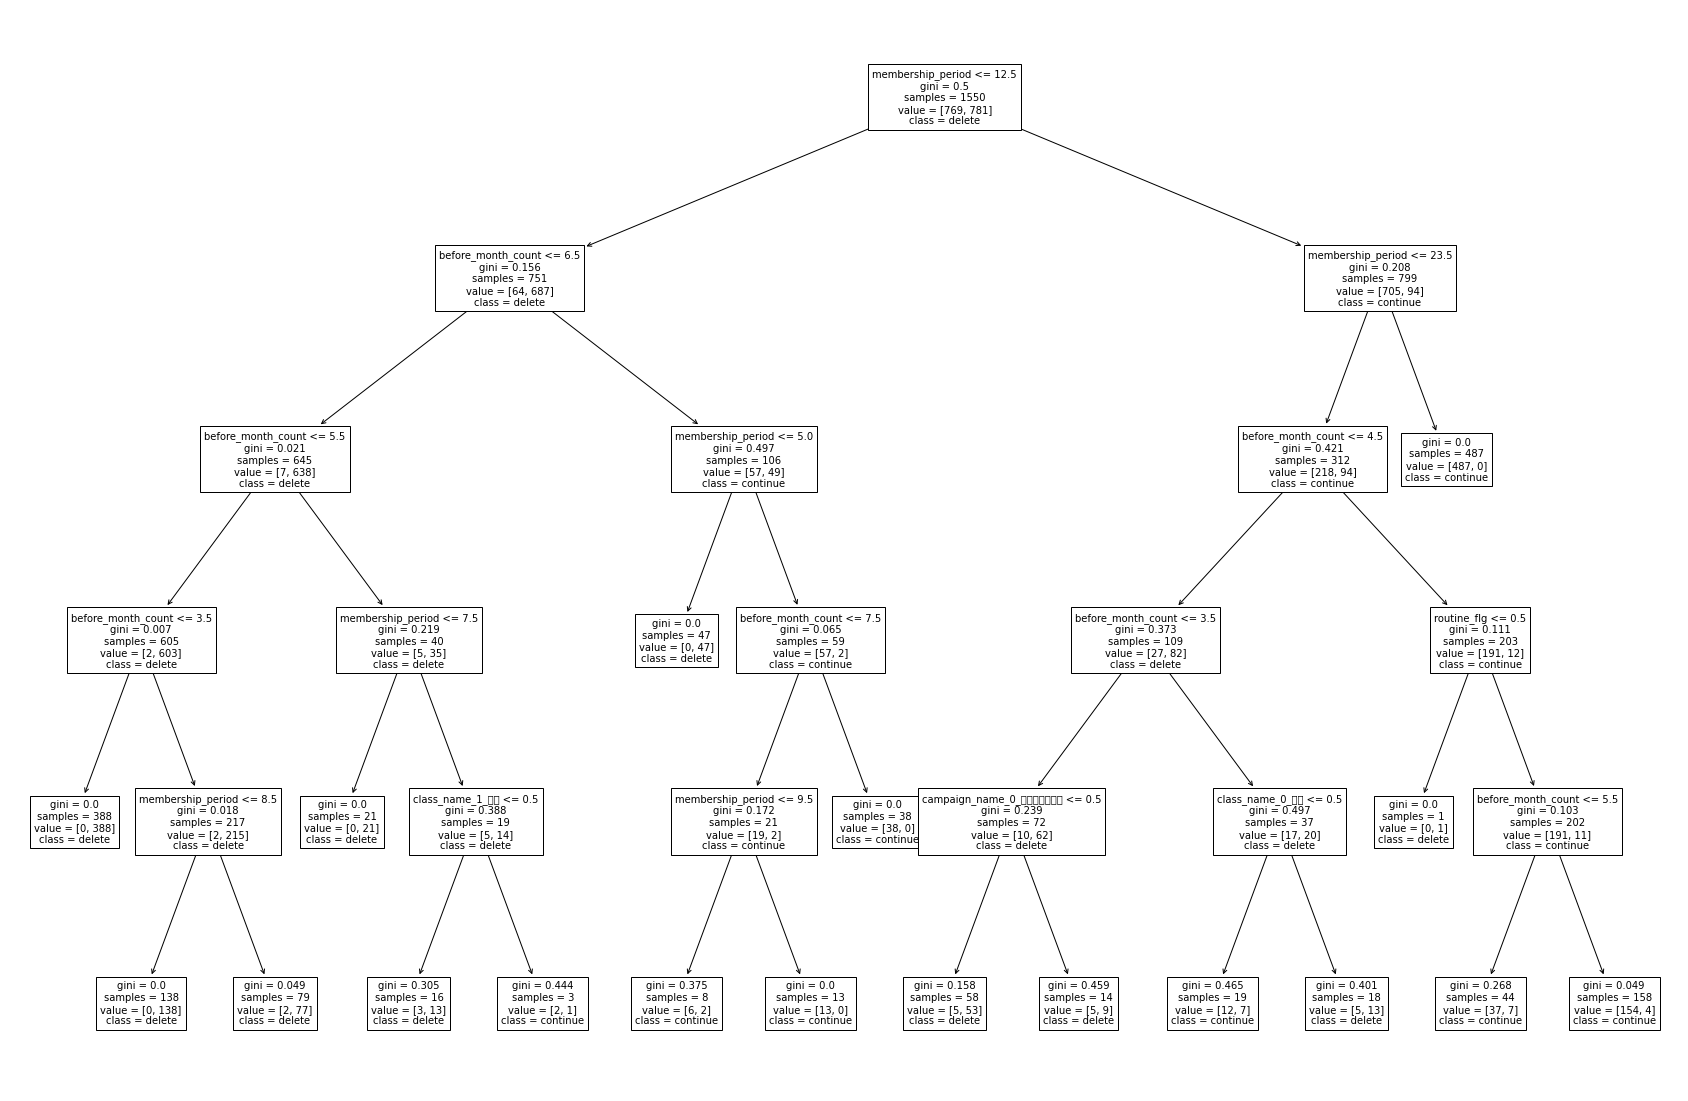

In [89]:
from sklearn import tree
import matplotlib.pyplot as plt
plt.figure(figsize=(30,20))
tree.plot_tree(model, fontsize=10,
              feature_names = X.columns,
              class_names=['continue', 'delete'])
plt.show()

In [92]:
x_test.columns

Index(['before_month_count', 'routine_flg', 'membership_period',
       'campaign_name_0_입회비반액할인', 'campaign_name_1_입회비무료', 'class_name_0_종일',
       'class_name_1_주간', 'gender_F'],
      dtype='object')

In [93]:
before_month_count = 3
routine_flg = 0
membership_period = 5
campaign_name_0_입회비반액할인 = 1
campaign_name_1_입회비무료 = 0
class_name_0_종일 = 1
class_name_1_주간 = 0
gender_F = 1

input_data = [before_month_count ,routine_flg ,membership_period, campaign_name_0_입회비반액할인 ,
              campaign_name_1_입회비무료 ,class_name_0_종일 ,class_name_1_주간 ,gender_F ]

In [96]:
is_deleted = model.predict([input_data]) # 1 => 탈퇴
percent_is_deleted = model.predict_proba([input_data])

print(is_deleted)
print(percent_is_deleted)

# 위의 값을 변경해보고 처음부터 다시 확인해보세요~! 40분까지

[1.]
[[0. 1.]]


- 그룹바이, 시각화 풀어보기
- 시각화 ppt 자료 만드는 것
- 머신러닝 쪽 ppt 자료 만든는 것